# Generative AI application in Humanitarian and Crisis Response

While reflecting on the possibilities of Generative AI (GenAI), I began to consider how I could combine my background in geodata science with the power of GenAI to address real-world challenges. One area that stood out is disaster response, a field where timely, reliable information can save lives.

In urgent humanitarian crises, real-time information becomes crucial. Crowdsourced platforms like Ushahidi and PeaceEye have demonstrated the value of user-generated reports during natural disasters and conflicts. In these situations, location-based data is especially vital, enabling responders to act quickly and effectively.

During the Google and Kaggle GenAI intensive course, I learned how Large Language Models (LLMs) can be leveraged to process and generate human-like text, summarize large volumes of data, create agents, undersatnd images and extract insights from inputs among others. This sparked my curiosity:

How then can we use GenAI to analyze and enhance crowdsourced data in crisis situations?

This notebook provides:

+ An overview of GenAI concepts I explored during the course

+ A use-case application: integrating LLMs into a disaster response workflow

Ideas on possible use cases:

- Summarize citizen reports

- Detect urgency levels

- Identify misinformation

- Assist in multi-language translation

- Extract structured data from unstructured text (e.g., location, time, resource needs) using GoogleMaps API for example.



In [1]:
!pip uninstall -qqy jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q 'google-genai==1.7.0' 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.3/433.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 9.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 3.10.2 requi

Import the Google GenAI SDK to have programmatic acess to Foundational Models in the Gemini family as well as some helpers for rendering the output.

In [2]:
from google import genai
from google.genai import types
from google.genai.types import Part

from IPython.display import HTML, Markdown, display,Image
from typing import Annotated
from typing_extensions import TypedDict

#from langgraph.graph.message import add_messages

### Set up API key
This is stored in the Colab Secret named GOOGLE_API_KEY

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

Explore the multimodal Gemini model family.

Notes:
- Language models that predict probability of a sequence of words
- transformer based architecture
- input as vector embeddings-input could be images,text,audio or video
- embeddings stored in a vector database

In [4]:
client = genai.Client(api_key=GOOGLE_API_KEY)
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01

### Few shot prompting

Prompt engineering- guiding LLMs to yield desired output by providing instructions,examples or other additional background information for context.

In this case, we need the output to be in a specific format given some specific instructions.

In [5]:
#select a model
model_id="gemini-2.0-flash-001"

# An example is provided to guide the model in how it should respond i.e. output as json format

few_shot_prompt = """Parse through crowdsourced text, geo-tagged reports on platforms like Ushahidi
that describe what is happening during emergencies, conflicts, elections, or natural disasters. :

EXAMPLE:
Guns shots heard near Toi Market. 3 students caught in the line of fire, ambulances on site.
JSON Response:
```
{
"Type": "gun-violence",
"Location": "Toi Market",
"Impact": "3",
"Response": Ambulances"
}
```

EXAMPLE:
Our house in Uthiru is submerged in flood water. Please help us, a family of six is stranded in the house.
JSON Response:
```
{
"Type": "Floods",
"Location": "Uthiru",
"No of Casualties": "6",
"Response":
}
```


"""

crowdsourced_input = "Mount Etna is quite invisible today. Lots of smoke and tremors near our town in Sicily"

#sampling controls, temperature,top-p to control selection of tokesn whose cumulative probability does not exceed a value P, usually between 0 and 1. A 0 value means the model will always pick the most likely word while a 1 means all tokens are considered hence introducing randomness
response = client.models.generate_content(
    model=model_id,
    config=types.GenerateContentConfig(
        temperature=0.9, #lower value means tokens with higher probability are selected but higher values means all tokens have high probability of being selected as the next prediction hence more random
        top_p=0.99, #looks at all token probabilities and picks from those who combined chances adds upto 0.99 which in this case means randomness
        max_output_tokens=250, # control length of response
    ),
    contents=[few_shot_prompt, crowdsourced_input])

print(response.text)

```json
{
"Type": "Volcanic Activity",
"Location": "Sicily",
"Details": "Smoke and tremors",
"Response": null
}
```



### Image understanding

Users often upload images of events, which can provide rich contextual information that may not be fully captured through text alone. Gemini 2.5 models like gemini-2.5-pro-exp-03-25 offer powerful spatial understanding capabilities. These models can perform tasks like object detection, image segmentation enabling automated extraction of critical details from images such as the presence of injured individuals, damaged infrastructure or visible threats. These would enhance situational awareness in disaster response applications.


In [6]:
# example of a model with spatial understanding capabilities
model_name = "gemini-2.5-pro-exp-03-25"

In [7]:
# system prompt to define model's capabilities
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
      """
     

In [8]:
#To control misinformation or sharing of sensitive content
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

Let's visualise one example of an such an image

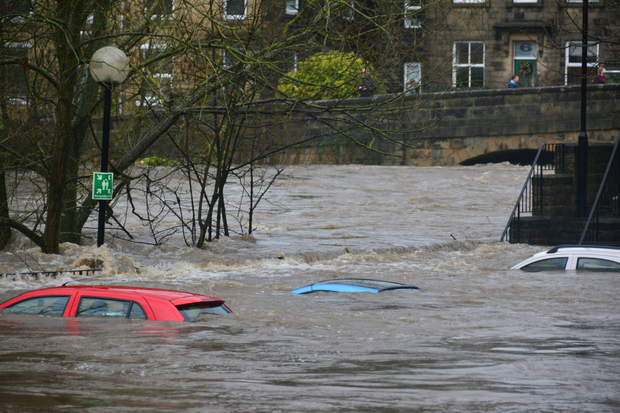

In [9]:
import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
image_url = "/kaggle/input/sample-data/chris-gallagher-4zxp5vlmvnI-unsplash.jpg"
im = Image.open(image_url)
im.thumbnail([620,620], Image.Resampling.LANCZOS)
im

In [10]:
# a prompt that provides context
image_prompt = """
For humanitarian and conflict resolution purposes, you are provided an image and are required to explain what is happening in that regard. In the format provided and summarised.
For example, what kind of disaster is in the image

Provide recommendation for the type of response that would be ideal in such a situation.
"""

In [11]:
import typing_extensions as typing
# What happened, how it affected people, and what should be done about it. Three things the model should extract from the image
class ImageDesc(typing.TypedDict):
    Disaster_Identification: str
    Humanitarian_Implications: str
    Recommended_Response: str
    
# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[image_prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        response_schema=ImageDesc,
        safety_settings=safety_settings,
    )
)
# Check output
print(response.text)
     

```json
[
  {"box_2d": [691, 0, 779, 375], "label": "Submerged red car"},
  {"box_2d": [647, 466, 715, 693], "label": "Submerged blue car roof"},
  {"box_2d": [598, 824, 661, 1000], "label": "Submerged white car"},
  {"box_2d": [100, 145, 598, 209], "label": "Streetlight"},
  {"box_2d": [401, 146, 482, 184], "label": "Emergency exit sign"},
  {"box_2d": [240, 678, 401, 1000], "label": "Bridge"},
  {"box_2d": [0, 0, 250, 998], "label": "Building"},
  {"box_2d": [401, 809, 598, 998], "label": "Stairs and railing"},
  {"box_2d": [127, 446, 240, 609], "label": "Green bush"},
  {"box_2d": [100, 0, 600, 172], "label": "Tree trunk left"},
  {"box_2d": [269, 190, 590, 445], "label": "Bare trees center"}
]
```

**Disaster Type:**
Flood

**Summary:**
The image shows a significant flood event in what appears to be an urban or semi-urban area. Floodwaters have risen substantially, submerging multiple vehicles and reaching high levels against buildings and infrastructure like bridges and streetligh

### Code generation

Another capabilitiy offered by LLMs is generating code and providing explanation

In [20]:
#Use the generated bounding boxes to draw on image using code generation
from pprint import pprint

code_exec_prompt = """
As a geospatial analyst working on a crowdsourced disaster response platform, you are tasked with extracting key visual information from user-uploaded images. These insights include identifying:

- The type of disaster
- Objects of interest (e.g., damaged buildings, vehicles, people in distress, fire, water, etc.)
- Contextual clues to inform humanitarian response

Let's work with the following example image uploaded by a user:
image_url = "/kaggle/input/sample-data/chris-gallagher-4zxp5vlmvnI-unsplash.jpg"

Load and resize the image for display
from PIL import Image
im = Image.open(image_url)
im.thumbnail([620, 620], Image.Resampling.LANCZOS)
im

For humanitarian and conflict-resolution purposes, generate bounding boxes around important visual elements in the image. These detections will help guide field teams and decision-makers during disaster response efforts.

Based on the genearted bounding boxes,step-by-step, write a Python script that:
1. Loads the image
2. Plots these bounding boxes in the image
3. Displays the annotated image
Do not use object detection models but rather a LLM such as gemini-2.5-pro-exp-03-25 to detect
"""

# config = types.GenerateContentConfig(
#     system_instruction=bounding_box_system_instructions,  # bboxes as json output
#     tools=[types.Tool(code_execution=types.ToolCodeExecution())],
# )


response = client.models.generate_content(
    model=model_name,
    contents=[code_exec_prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    )
)

# response = client.models.generate_content(
#     model='gemini-2.5-pro-exp-03-25',
#     config=config,
#     contents=[code_exec_prompt,image_prompt, im])

for part in response.candidates[0].content.parts:
    if part.text:
        display(Markdown(part.text))
    elif part.executable_code:
        display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    elif part.code_execution_result:
        if part.code_execution_result.outcome != 'OUTCOME_OK':
            display(Markdown(f'## Status {part.code_execution_result.outcome}'))

        display(Markdown(f'```\n{part.code_execution_result.output}\n```'))

```json
[
  {"box_2d": [681, 0, 779, 375], "label": "Red Car (Submerged)"},
  {"box_2d": [600, 818, 664, 1000], "label": "White Car (Submerged)"},
  {"box_2d": [620, 452, 711, 693], "label": "Blue Car Roof (Submerged)"},
  {"box_2d": [83, 143, 480, 214], "label": "Street Lamp (Partially Submerged)"},
  {"box_2d": [402, 142, 480, 188], "label": "Green Sign (Partially Submerged)"},
  {"box_2d": [0, 214, 301, 997], "label": "Building (Background)"},
  {"box_2d": [223, 579, 346, 998], "label": "Bridge/Walkway"},
  {"box_2d": [240, 508, 314, 544], "label": "Person (on walkway)"},
  {"box_2d": [245, 773, 301, 800], "label": "Person (on walkway)"},
  {"box_2d": [255, 885, 301, 914], "label": "Person (on walkway)"},
  {"box_2d": [115, 0, 520, 158], "label": "Tree (Left, Submerged Base)"},
  {"box_2d": [140, 214, 511, 509], "label": "Trees (Center, Submerged Base)"},
  {"box_2d": [559, 871, 600, 998], "label": "Stairs (Submerged Base)"}
]
```

```python
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os

# Define the bounding box data as a JSON string
# (Using the JSON generated in the previous step)
bounding_boxes_json = """
[
  {"box_2d": [681, 0, 779, 375], "label": "Red Car (Submerged)"},
  {"box_2d": [600, 818, 664, 1000], "label": "White Car (Submerged)"},
  {"box_2d": [620, 452, 711, 693], "label": "Blue Car Roof (Submerged)"},
  {"box_2d": [83, 143, 480, 214], "label": "Street Lamp (Partially Submerged)"},
  {"box_2d": [402, 142, 480, 188], "label": "Green Sign (Partially Submerged)"},
  {"box_2d": [0, 214, 301, 997], "label": "Building (Background)"},
  {"box_2d": [223, 579, 346, 998], "label": "Bridge/Walkway"},
  {"box_2d": [240, 508, 314, 544], "label": "Person (on walkway)"},
  {"box_2d": [245, 773, 301, 800], "label": "Person (on walkway)"},
  {"box_2d": [255, 885, 301, 914], "label": "Person (on walkway)"},
  {"box_2d": [115, 0, 520, 158], "label": "Tree (Left, Submerged Base)"},
  {"box_2d": [140, 214, 511, 509], "label": "Trees (Center, Submerged Base)"},
  {"box_2d": [559, 871, 600, 998], "label": "Stairs (Submerged Base)"}
]
"""

# --- Python Script ---

# 1. Load the image
image_path = 'input_file_0.jpeg'
try:
    img = Image.open(image_path).convert("RGB")
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    # Handle error appropriately, maybe exit or use a default image
    exit()

# 2. Parse the bounding box data
try:
    bounding_boxes = json.loads(bounding_boxes_json)
except json.JSONDecodeError:
    print("Error: Invalid JSON data for bounding boxes.")
    exit()

# Create a drawing object
draw = ImageDraw.Draw(img)

# Define colors for boxes (cycle through a few)
colors = ["red", "lime", "blue", "yellow", "cyan", "magenta", "orange"]
color_index = 0

# Attempt to load a default font, handle potential errors
try:
    # Try a common font, adjust path if necessary or use a fallback
    # On Kaggle, default fonts might be limited. Let's try finding one.
    # Common paths: '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf'
    # If that fails, PIL might use a basic default.
    font_path = '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf'
    if os.path.exists(font_path):
         font = ImageFont.truetype(font_path, 15)
    else:
         # print("Default font not found, using PIL default.")
         font = ImageFont.load_default() # Fallback
except IOError:
    # print("Font loading error, using PIL default.")
    font = ImageFont.load_default() # Fallback if any error occurs


# 3. Plot bounding boxes and labels
for i, item in enumerate(bounding_boxes):
    box = item['box_2d']
    label = item['label']
    color = colors[i % len(colors)] # Cycle through colors

    # Draw rectangle
    draw.rectangle(box, outline=color, width=3)

    # Add label text
    text_position = (box[0] + 2, box[1] + 2) # Position slightly inside top-left corner
    # Draw a small background rectangle for text visibility
    # text_bbox = draw.textbbox(text_position, label, font=font) # Use textbbox in newer Pillow
    # For compatibility or if textbbox is not available: estimate size or just draw text
    # draw.rectangle(text_bbox, fill=color) # Optional background for text
    draw.text(text_position, label, fill="white", font=font) # Draw text over background

# 4. Display the annotated image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off') # Hide axes
plt.title("Image with Bounding Boxes")
plt.show()
```

Okay, I have the image and the bounding box data generated previously.

Now, I will execute the Python script to:
1.  Load the image (`input_file_0.jpeg`).
2.  Parse the bounding box JSON data.
3.  Draw the bounding boxes and labels onto the image.
4.  Display the resulting annotated image.


```python
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os

# Define the bounding box data as a JSON string
# (Using the JSON generated in the previous step)
bounding_boxes_json = """
[
  {"box_2d": [681, 0, 779, 375], "label": "Red Car (Submerged)"},
  {"box_2d": [600, 818, 664, 1000], "label": "White Car (Submerged)"},
  {"box_2d": [620, 452, 711, 693], "label": "Blue Car Roof (Submerged)"},
  {"box_2d": [83, 143, 480, 214], "label": "Street Lamp (Partially Submerged)"},
  {"box_2d": [402, 142, 480, 188], "label": "Green Sign (Partially Submerged)"},
  {"box_2d": [0, 214, 301, 997], "label": "Building (Background)"},
  {"box_2d": [223, 579, 346, 998], "label": "Bridge/Walkway"},
  {"box_2d": [240, 508, 314, 544], "label": "Person (on walkway)"},
  {"box_2d": [245, 773, 301, 800], "label": "Person (on walkway)"},
  {"box_2d": [255, 885, 301, 914], "label": "Person (on walkway)"},
  {"box_2d": [115, 0, 520, 158], "label": "Tree (Left, Submerged Base)"},
  {"box_2d": [140, 214, 511, 509], "label": "Trees (Center, Submerged Base)"},
  {"box_2d": [559, 871, 600, 998], "label": "Stairs (Submerged Base)"}
]
"""

# --- Python Script ---

# 1. Load the image
image_path = 'input_file_0.jpeg'
try:
    img = Image.open(image_path).convert("RGB")
    print(f"Image '{image_path}' loaded successfully. Size: {img.size}")
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    exit()
except Exception as e:
    print(f"Error loading image: {e}")
    exit()

# 2. Parse the bounding box data
try:
    bounding_boxes = json.loads(bounding_boxes_json)
    print(f"Successfully parsed {len(bounding_boxes)} bounding boxes.")
except json.JSONDecodeError as e:
    print(f"Error: Invalid JSON data for bounding boxes. {e}")
    exit()
except Exception as e:
    print(f"Error processing JSON: {e}")
    exit()


# Create a drawing object
draw = ImageDraw.Draw(img)

# Define colors for boxes (cycle through a few)
colors = ["red", "lime", "blue", "yellow", "cyan", "magenta", "orange", "purple", "green"]
color_index = 0

# Attempt to load a default font, handle potential errors
try:
    # Try a common font, adjust path if necessary or use a fallback
    font_path = '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf'
    if os.path.exists(font_path):
         font = ImageFont.truetype(font_path, 15)
         # print("Using DejaVuSans font.")
    else:
         # print("DejaVuSans font not found, using PIL default.")
         font = ImageFont.load_default() # Fallback
except IOError:
    # print("Font loading error, using PIL default.")
    font = ImageFont.load_default() # Fallback if any error occurs
except Exception as e:
    # print(f"Unexpected font error: {e}. Using PIL default.")
    font = ImageFont.load_default()


# 3. Plot bounding boxes and labels
print("Drawing bounding boxes and labels...")
for i, item in enumerate(bounding_boxes):
    try:
        box = item['box_2d']
        label = item['label']
        color = colors[i % len(colors)] # Cycle through colors

        # Ensure box coordinates are integers/floats and in the correct order (xmin, ymin, xmax, ymax)
        if not (isinstance(box, list) and len(box) == 4 and all(isinstance(coord, (int, float)) for coord in box)):
            print(f"Skipping invalid box data for item {i}: {box}")
            continue
        if box[0] >= box[2] or box[1] >= box[3]:
            print(f"Skipping invalid box dimensions (min >= max) for item {i}: {box}")
            continue

        # Draw rectangle
        draw.rectangle(box, outline=color, width=3)

        # Add label text
        text_position = (box[0] + 2, box[1] + 2) # Position slightly inside top-left corner

        # Draw text background rectangle for better visibility
        try:
            # Use textbbox if available (newer Pillow versions)
            text_bbox = draw.textbbox(text_position, label, font=font)
            # Add a small padding
            bg_box = (text_bbox[0]-1, text_bbox[1]-1, text_bbox[2]+1, text_bbox[3]+1)
            draw.rectangle(bg_box, fill=color)
        except AttributeError:
            # Fallback if textbbox is not available (older Pillow versions)
            # Estimate background size or just skip background
            pass # Skipping background rectangle in fallback

        # Draw the text itself
        draw.text(text_position, label, fill="black", font=font) # Use black text on colored background

    except Exception as e:
        print(f"Error drawing box/label for item {i}: {item}. Error: {e}")


# 4. Display the annotated image
print("Displaying annotated image...")
plt.figure(figsize=(12, 10)) # Adjusted figure size for better viewing
plt.imshow(img)
plt.axis('off') # Hide axes
plt.title("Flood Image with Annotated Objects", fontsize=14)
plt.show()
print("Script finished.")
```

```
Image 'input_file_0.jpeg' loaded successfully. Size: (620, 413)
Successfully parsed 13 bounding boxes.
Drawing bounding boxes and labels...
Displaying annotated image...
Script finished.

```

The script successfully loaded the image, parsed the bounding box data, and drew the annotations. The final image with the bounding boxes and labels is displayed above. Each identified object relevant to the flood disaster scenario is highlighted.

### Agents
One approach involves building a user interface (UI) that hosts a chat assistant, designed to gather information directly from users during or after an event. The assistant can then generate a more **informative and comprehensive narrative** based on the user's input.

This has been implemented using the open-source Python package **[Gradio](https://www.gradio.app/)**. Once built, the app can be deployed on platforms like **[Hugging Face Spaces](https://huggingface.co/spaces)**, making it accessible to a wider audience and easy to integrate into a larger disaster response workflow.

This agent helps:
- Collect firsthand incident reports
- Refine user input into structured, analyzable summaries

In [21]:
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 80.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.8 MB/s eta 0:00:00


In [23]:
import gradio as gr


def sentence_builder(Casualties, Event, Location, Time, Situation_Report, Response):
    response_text = "Response is needed urgently." if not Response else "Response efforts in place."
    
    # Incorporate Time and Situation_Report into the output
    return f"""At {Time}, a {Event} occurred in {Location}, affecting approximately {Casualties} people. {Situation_Report}. {response_text}"""


iface = gr.Interface(
    sentence_builder,
    [
        gr.Slider(0, 500, label="Estimated Casualties"),
        gr.Dropdown(["Floods", "Earthquake", "Volcanic eruption", "Gun violence", "Landslides", "Fire"], label="Type of Event"),
        gr.Textbox(label="Location", placeholder="Enter the location"),
        gr.Textbox(label="Time of report", placeholder="Enter the time"),
        gr.Textbox(label="Observation", placeholder="What is the situation"),
        gr.Checkbox(label="Has response been deployed?"),
    ],
    "text",
    examples=[
        [0, "Volcanic eruption", "Sicily", "10:25pm", "Sightings of fires", False],
        [300, "Floods", "Mathare Primary School", "12:00 noon", "Water levels rising", False],
        [100, "Earthquake", "Salzburg near Taxham", "03:00am", "cracks on buildings", True],
    ],
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7861
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://81c693f517474c5570.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
